In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
import seaborn as sns
from sklearn import linear_model
import sklearn as sk
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import mixedlm
import statsmodels as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats as ss
from scipy import stats
import scipy.io as sio
from statsmodels import robust
%matplotlib inline

In [2]:
#get rid of scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
fish = pd.read_csv('fish_100.csv', sep = ",")

### Calculate fatigue

In [6]:
fish['tap_count']=[1]*len(fish)
# fatigue per environment

In [7]:
tap = fish.groupby(['id', 'environment'])['tap_count'].cumsum().reset_index(name = 'fatigue')

In [8]:
tap = tap.reset_index().set_index('index')
tap = tap.drop('level_0', axis =1)

In [9]:
fish = tap.merge(fish, left_index = True, right_index=True,how='inner')

### Exclusion List

In [10]:
fish = fish[~fish.id.isin([668262.0, 675528.0, 675577.0, 680119.0, 672593.0, 683242.0, 675654.0])]
# failed sound check questions 

### Missing Values

In [11]:
fish.isnull().sum()
fish = fish[fish.latency.notnull()]

Checkpoint

In [13]:
len(fish.id.unique()) #93

93

### Environment + latency

In [15]:
fish['environment_binary'] = np.where(fish['environment']=='low', 0, fish['environment'])
fish['environment_binary'] = np.where(fish['environment']=='high', 1, fish['environment'])
fish['environment_binary'] = np.where(fish['environment']=='low', 0, fish['environment_binary'])
fish['environment_binary'] = np.where(fish['environment']=='high', 1, fish['environment_binary'])
fish['log_latency'] = np.log(fish['latency'])

# Log Linear Model

Need to pick an optimizer.
<br>Matlab uses either 'bfgs' or 'lbfgs'. But Matlab doesn't give convergence information.


In [25]:
f_model = mixedlm(formula = 'log_latency ~ 1 + environment_binary + price_displayed + fatigue',
                  groups = fish['id'],
                  re_formula = "~environment_binary + price_displayed + fatigue",
                  data = fish)

r = f_model.fit(reml = False, method = 'powell')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [26]:
print(r.summary())

                          Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           log_latency
No. Observations:             289165            Method:                       ML         
No. Groups:                   93                Scale:                        0.0485     
Min. group size:              1290              Likelihood:                   26157.4280 
Max. group size:              4443              Converged:                    Yes        
Mean group size:              3109.3                                                     
-----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                      5.239    0.021 251.150 0.000  5.198  5.280
environment_binary[T.1]             

### Calculate AIC

In [28]:
sm.tools.eval_measures.aic(26157.4280, 289165, 4)

-52306.856

## Random Effects

In [29]:
r_params = pd.DataFrame(r.params,columns=['LMM'])
random_effects = pd.DataFrame(r.random_effects)
random_effects = random_effects.transpose()
random_effects = random_effects.rename(index=str, columns={'groups': 'LMM'})

In [31]:
len(random_effects) # 93

93

In [32]:
random_effects.head(2)

,Group,environment_binary[T.1],price_displayed,fatigue
668220.0,-0.078,0.037,0.004,-0.000
668225.0,0.127,-0.122,-0.086,-0.000


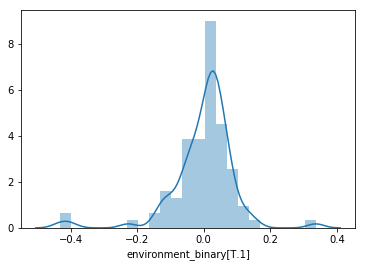

In [33]:
sns.distplot(random_effects['environment_binary[T.1]'])

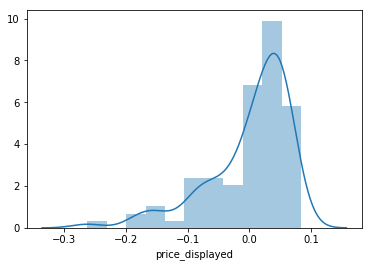

In [35]:
sns.distplot(random_effects['price_displayed'])

## Environment betas and tap difference

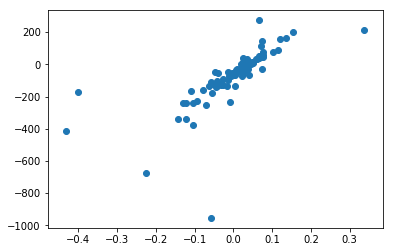

In [37]:
tap = fish.groupby(['id', 'environment'])['tap_count'].sum().reset_index(name = 'difference')
tap = tap.groupby(tap.index//2)['difference'].diff(-1).dropna().reset_index()

y = -1*tap['difference']
x = random_effects['environment_binary[T.1]']
plt.scatter(x, y)